In [0]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import numpy as np

from torch.autograd import Variable
from matplotlib import pyplot as plt

torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = 'cuda'

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


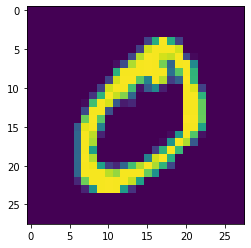

In [0]:
#We will load the MNIST dataset here.

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform )

test_data = torchvision.datasets.MNIST(root = './data',train = False ,download = True,  transform = transform)

 

print(train_data)
print(test_data)

plt.imshow(np.asarray(train_data[1][0].reshape(28,28)))



In [0]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader (train_data, batch_size = BATCH_SIZE, )
test_loader = torch.utils.data.DataLoader (test_data, batch_size = 1, )

# train_loader.to('cuda')
# test_loader.to('cuda')


print(train_loader)

We will define our network in the following cell. There are several ways of doing this in PyTorch, but in this example we will do it by subclassing nn.module.

Our network will have 4 convolutional layers followed by 2 fully-connected layers.


In [0]:
class MyConvNet(nn.Module):
  def __init__(self):
    super(MyConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3) #Only black and while input channel.
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3)
    self.conv3 = nn.Conv2d(64, 64, kernel_size = 5)
    self.conv4 = nn.Conv2d(64, 64, kernel_size = 5)

    self.dense1 = nn.Linear(64*3*3, 64)
    self.dense2 = nn.Linear(64, 128)
    self.dense3 = nn.Linear(128, 64)
    self.dense4 = nn.Linear(64, 16)
    self.dense5 = nn.Linear(16, 1)

  def forward (self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))

    x = F.relu(F.max_pool2d(self.conv3(x), 2))
    x = F.relu(F.max_pool2d(self.conv4(x), 2))

    x = x.view(-1, 3*3*64)
    x = F.relu(self.dense1(x))
    x = F.relu(self.dense2(x))
    x = F.relu(self.dense3(x))
    x = F.relu(self.dense4(x))
    x = self.dense5(x)


    return x    


In [0]:
#Setting few things up

net = MyConvNet()
net.to('cuda')
print(net)
tld = iter(train_loader)
im = next(tld)[0].to(device)
print (net.forward(im))


MyConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (dense1): Linear(in_features=576, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=64, bias=True)
  (dense4): Linear(in_features=64, out_features=16, bias=True)
  (dense5): Linear(in_features=16, out_features=1, bias=True)
)
tensor([[0.2167],
        [0.2164],
        [0.2160],
        [0.2166],
        [0.2162],
        [0.2163],
        [0.2164],
        [0.2166],
        [0.2162],
        [0.2164],
        [0.2165],
        [0.2163],
        [0.2164],
        [0.2167],
        [0.2164],
        [0.2162],
        [0.2166],
        [0.2168],
        [0.2163],
        [0.2165],
        [0.2158],
        [0.2164],
        [0.2164],
        [0.21

In [0]:
def test(model, test_loader):
    correct = 0 
    for test_imgs, test_labels in test_loader:
        test_imgs = Variable(test_imgs).to(device)
        output = model(test_imgs)
        predicted = torch.max(output,axis = 1).indices
        correct += (predicted == test_labels).sum()
        # print(predicted, test_labels)
        # print(correct)
    print("Test accuracy:{:.3f}% ".format( float(correct * 100) / (len(test_loader))))


def train(model, train_loader, EPOCHS = 25, lossF = None):
  if lossF == None:
    lossF = nn.MSELoss()
  optim = torch.optim.Adam (model.parameters(), lr = 4e-5, weight_decay=1e-7)
  model.train()
  for epoch in range(EPOCHS):
    correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
      var_X_batch = Variable(X_batch).to(device)
      var_y_batch = Variable(y_batch).to(device)
      # print(var_X_batch.size())
      output = model(var_X_batch)

      # print(output)
      # print(output.size(), var_y_batch.size())
      loss = lossF (output.float().view(32), var_y_batch.float().view(32))
      # loss = torch.exp(loss)
      # print(loss)
      loss.backward()
      optim.step()
      optim.zero_grad()

      predicted = output
      # print(predicted)
      # print (torch.abs(predicted.view(-1) - var_y_batch.view(-1)) < 0.45)
      correct += (torch.abs(predicted.view(-1) - var_y_batch.view(-1)) < 0.49999).sum()

      
      if (batch_idx % 200) == 0:
          print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))




In [0]:
train (net, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 20.932194	 Accuracy:6.250%
Epoch : 0 [6400/60000 (11%)]	Loss: 5.830895	 Accuracy:8.815%
Epoch : 0 [12800/60000 (21%)]	Loss: 4.525723	 Accuracy:8.339%
Epoch : 0 [19200/60000 (32%)]	Loss: 7.278857	 Accuracy:8.143%
Epoch : 0 [25600/60000 (43%)]	Loss: 3.662749	 Accuracy:8.294%
Epoch : 0 [32000/60000 (53%)]	Loss: 5.199687	 Accuracy:9.178%
Epoch : 0 [38400/60000 (64%)]	Loss: 2.524659	 Accuracy:10.249%
Epoch : 0 [44800/60000 (75%)]	Loss: 2.015491	 Accuracy:11.572%
Epoch : 0 [51200/60000 (85%)]	Loss: 3.170655	 Accuracy:12.886%
Epoch : 0 [57600/60000 (96%)]	Loss: 1.567123	 Accuracy:14.403%
Epoch : 1 [0/60000 (0%)]	Loss: 2.476189	 Accuracy:18.750%
Epoch : 1 [6400/60000 (11%)]	Loss: 1.656231	 Accuracy:30.846%
Epoch : 1 [12800/60000 (21%)]	Loss: 1.333561	 Accuracy:32.357%
Epoch : 1 [19200/60000 (32%)]	Loss: 1.616020	 Accuracy:32.836%
Epoch : 1 [25600/60000 (43%)]	Loss: 1.032303	 Accuracy:34.024%
Epoch : 1 [32000/60000 (53%)]	Loss: 3.885685	 Accuracy:34.806%
Epoch : 1

In [0]:
test(net, test_loader)

Test accuracy:9.800% 


Let's try to hallucinate 7 from our trained network and see what happens. For this we will need to change the network slightly.



In [0]:
def train_im(model, train_loader, digit = 7 ,iters = 10000, lossF = None):
  im = torch.zeros_like(train_data[1][0]).view(1, 1, 28, 28).to(device)
  im = Variable(im, requires_grad = True)
  digit = Variable(torch.tensor(digit)).to(device).view(1)
  if lossF == None:
    lossF = nn.CrossEntropyLoss()
  optim = torch.optim.Adam ([im, ], lr = 4e-1, weight_decay=1e-3)
  model.train()
  im_history = []
  for it in range(iters):
    
    output = model(im)
    # print(output)
    loss = lossF (output, digit)
    loss.backward()
    optim.step()
    optim.zero_grad()

    
    # if (it % 200) == 0:
    #     print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
    #               epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

  return im

In [0]:
im = train_im (net, train_loader, digit=7)

RuntimeError: ignored

In [0]:
im = np.asarray(im.view(28, 28).cpu().detach())


In [0]:
plt.imshow(im)

In the cell below we will hallucinate all the digits from 0 to 9 each for 1000 iterations and will print the results.

In [0]:
for i in range (10):
  im = train_im (net, train_loader, digit=i)
  im = np.asarray(im.view(28, 28).cpu().detach())
  print (i)
  plt.imshow(im)
  plt.show()